In [6]:
import pandas as pd
from scipy.stats import spearmanr
import gensim
import numpy as np

model1 = gensim.models.Word2Vec.load("models/chunk_1/democrats_2021_2024.model")
model2 = gensim.models.Word2Vec.load("models/chunk_1/republican_2021_2024.model")
model3 = gensim.models.Word2Vec.load("models/chunk_1/conservative_2021_2024.model")
model4 = gensim.models.Word2Vec.load("models/chunk_1/backpacking_2021_2024.model")

In [ ]:

def get_top_n_words(model, n=1000):
    """Get top n words by frequency from a gensim Word2Vec model."""
    return [word for word, vocab_obj in sorted(model.wv.key_to_index.items(), key=lambda x: model.wv.get_vecattr(x[0], "count"), reverse=True)[:n]]

def get_overlap_and_rankcorr(model1, model2, n=1000):
    """
    Get top N words for each model, compute overlap and rank correlation.
    Returns: overlap set, overlap ratio, Spearman's rho
    """
    top1 = get_top_n_words(model1, n)
    top2 = get_top_n_words(model2, n)
    overlap = set(top1) & set(top2)
    overlap_ratio = len(overlap) / n

    # Get ranks for overlap words
    rank1 = {word: i for i, word in enumerate(top1)}
    rank2 = {word: i for i, word in enumerate(top2)}
    overlap_words = list(overlap)
    ranks1 = [rank1[w] for w in overlap_words]
    ranks2 = [rank2[w] for w in overlap_words]
    if len(overlap_words) > 1:
        rho, p = spearmanr(ranks1, ranks2)
    else:
        rho, p = None, None

    return {
        "overlap_words": overlap_words,
        "overlap_ratio": overlap_ratio,
        "spearman_rho": rho,
        "spearman_p": p
    }

# 用法示例
model1 = gensim.models.Word2Vec.load("models/chunk_1/democrats_2021_2024.model")
model2 = gensim.models.Word2Vec.load("models/chunk_1/republican_2021_2024.model")
model3 = gensim.models.Word2Vec.load("models/chunk_1/conservative_2021_2024.model")
model4 = gensim.models.Word2Vec.load("models/chunk_1/backpacking_2021_2024.model")

result = get_overlap_and_rankcorr(model1, model2, n=1000)
print(f"Overlap ratio: {result['overlap_ratio']:.3f}, Spearman rho: {result['spearman_rho']:.3f}")

result = get_overlap_and_rankcorr(model1, model3, n=1000)
print(f"Overlap ratio: {result['overlap_ratio']:.3f}, Spearman rho: {result['spearman_rho']:.3f}")

result = get_overlap_and_rankcorr(model1, model4, n=1000)
print(f"Overlap ratio: {result['overlap_ratio']:.3f}, Spearman rho: {result['spearman_rho']:.3f}")

Overlap ratio: 0.884, Spearman rho: 0.892
Overlap ratio: 0.877, Spearman rho: 0.879
Overlap ratio: 0.550, Spearman rho: 0.553


In [46]:
def print_sorted_overlap(model_a, model_b, n=1000, sort_by='a', top_k=50):
    top_a = get_top_n_words(model_a, n)
    top_b = get_top_n_words(model_b, n)
    overlap = set(top_a) & set(top_b)
    if sort_by == 'a':
        sorted_overlap = sorted(overlap, key=lambda w: model_a.wv.get_vecattr(w, "count"), reverse=True)
    else:
        sorted_overlap = sorted(overlap, key=lambda w: model_b.wv.get_vecattr(w, "count"), reverse=True)
    print(f"Top {top_k} overlap words (sorted by model_{sort_by} frequency):")
    print(sorted_overlap[:top_k])

# Example usage:
print_sorted_overlap(model1, model4, n=100, sort_by='b', top_k=10)

Top 10 overlap words (sorted by model_b frequency):
['get', 'like', 'one', 'use', 'day', 'good', 'time', 'would', 'also', 'people']


In [39]:
print("First 50 words in model1:")
print(get_top_n_words(model1, n=50))

print("\nFirst 50 words in model2:")
print(get_top_n_words(model2, n=50))

print("\nFirst 50 words in model3:")
print(get_top_n_words(model3, n=50))

print("\nFirst 50 words in model4:")
print(get_top_n_words(model4, n=50))

First 50 words in model1:
['remove', 'trump', 'people', 'get', 'like', 'vote', 'say', 'would', 'think', 'make', 'republican', 'one', 'know', 'good', 'win', 'want', 'need', 'right', 'time', 'see', 'even', 'biden', 'democrat', 'thing', 'state', 'take', 'year', 'election', 'way', 'also', 'really', 'still', 'party', 'could', 'look', 'much', 'give', 'bad', 'well', 'come', 'country', 'work', 'never', 'president', 'point', 'try', 'lose', 'mean', 'use', 'many']

First 50 words in model2:
['remove', 'people', 'get', 'like', 'trump', 'say', 'would', 'make', 'one', 'think', 'know', 'want', 'good', 'vote', 'right', 'republican', 'even', 'biden', 'see', 'democrat', 'time', 'need', 'thing', 'take', 'state', 'year', 'win', 'way', 'leave', 'also', 'country', 'use', 'come', 'look', 'bad', 'give', 'really', 'election', 'well', 'much', 'still', 'point', 'could', 'mean', 'work', 'never', 'party', 'try', 'back', 'government']

First 50 words in model3:
['remove', 'people', 'get', 'like', 'say', 'would', 'm

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import umap.umap_ as umap

def plot_model_umap_all(model, highlight_words=None, figsize=(12, 10)):
    """
    Reduce all words in the model to 2D using UMAP and plot.
    Color points by log-frequency. Optionally highlight specific words.
    """
    words = list(model.wv.key_to_index.keys())
    vectors = [model.wv[w] for w in words]
    vectors = vectors - np.mean(vectors, axis=0, keepdims=True)
    vectors = vectors / np.linalg.norm(vectors, axis=1, keepdims=True)
    freqs = np.array([model.wv.get_vecattr(w, "count") for w in words])
    log_freqs = np.log1p(freqs)

    reducer = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=23)
    coords = reducer.fit_transform(vectors)

    plt.figure(figsize=figsize)
    sc = plt.scatter(coords[:, 0], coords[:, 1], c=log_freqs, cmap="viridis", alpha=0.3, s=10)
    plt.colorbar(sc, label="log(Word Frequency + 1)")

    # Highlight words if provided
    if highlight_words:
        for word in highlight_words:
            if word in model.wv:
                idx = words.index(word)
                plt.scatter(coords[idx, 0], coords[idx, 1], color='red', s=80, label=word)
                plt.text(coords[idx, 0], coords[idx, 1], word, color='red', fontsize=12, weight='bold')
    plt.title("2D UMAP of All Word Embeddings (colored by log-frequency)")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.show()


# 用法示例
# plot_model_umap_all(model1, highlight_words=['remove', 'trump', 'people', 'get', 'like', 'vote', 'say', 'would', 'think', 'make'])
# plot_model_umap_all(model2, highlight_words=['remove', 'trump', 'people', 'get', 'like', 'vote', 'say', 'would', 'think', 'make'])
# plot_model_umap_all(model3, highlight_words=['remove', 'trump', 'people', 'get', 'like', 'vote', 'say', 'would', 'think', 'make'])

c:\Users\cyyua\DS\word_embedding\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


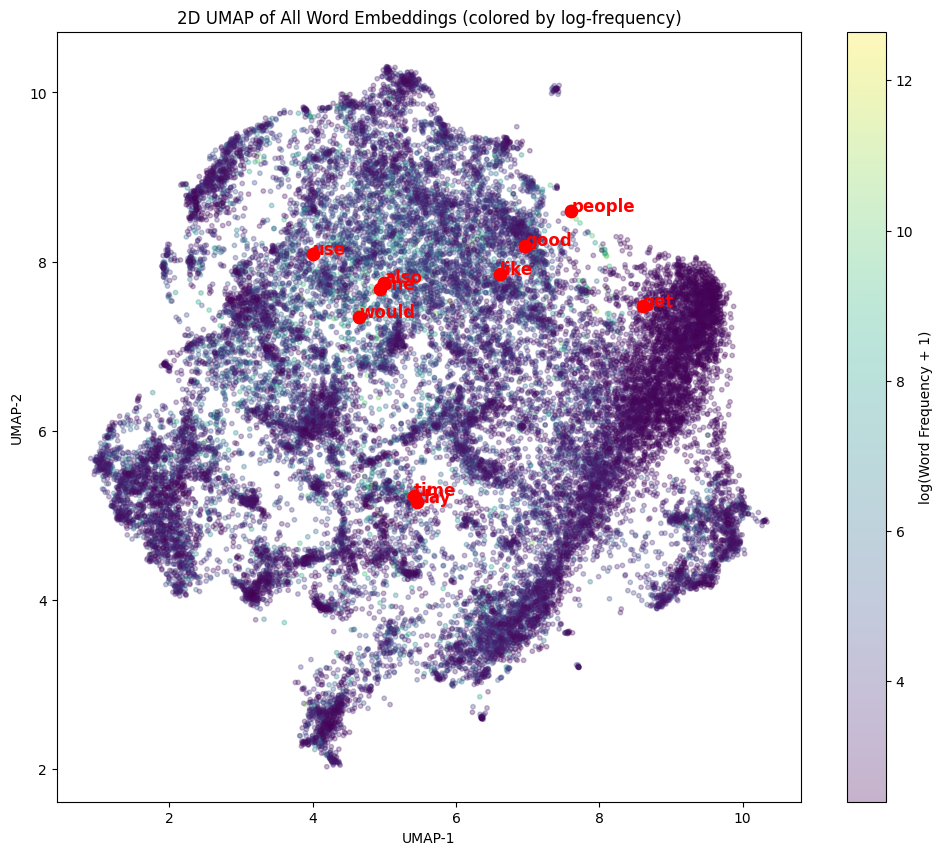

c:\Users\cyyua\DS\word_embedding\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


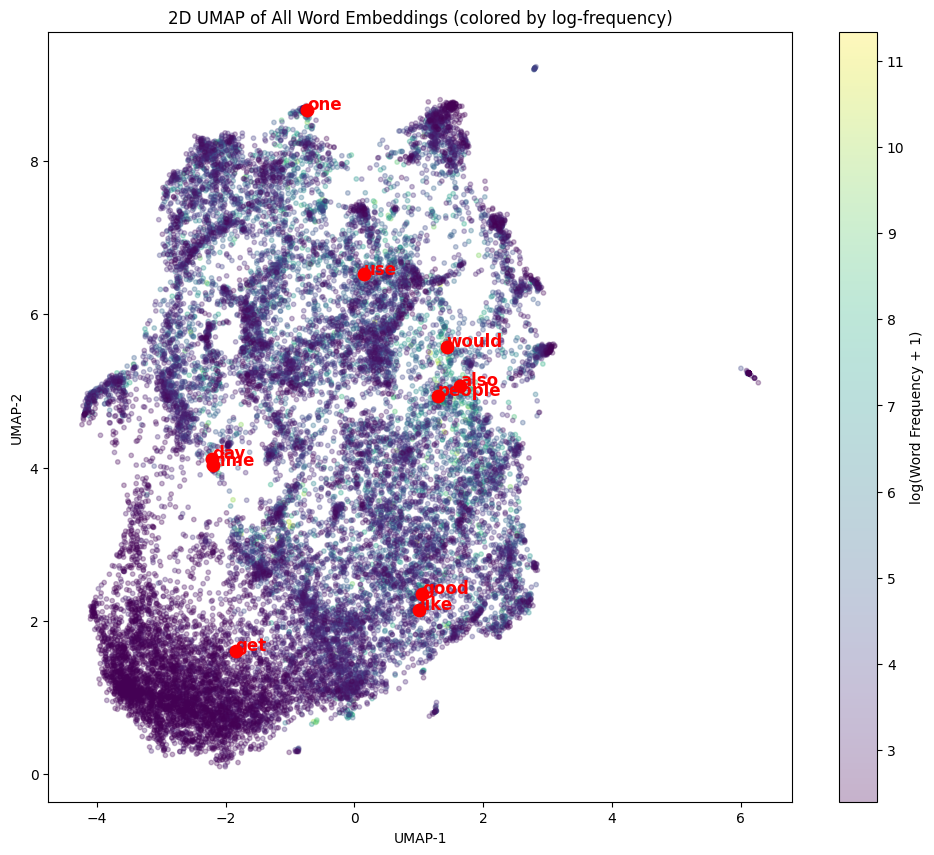

c:\Users\cyyua\DS\word_embedding\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


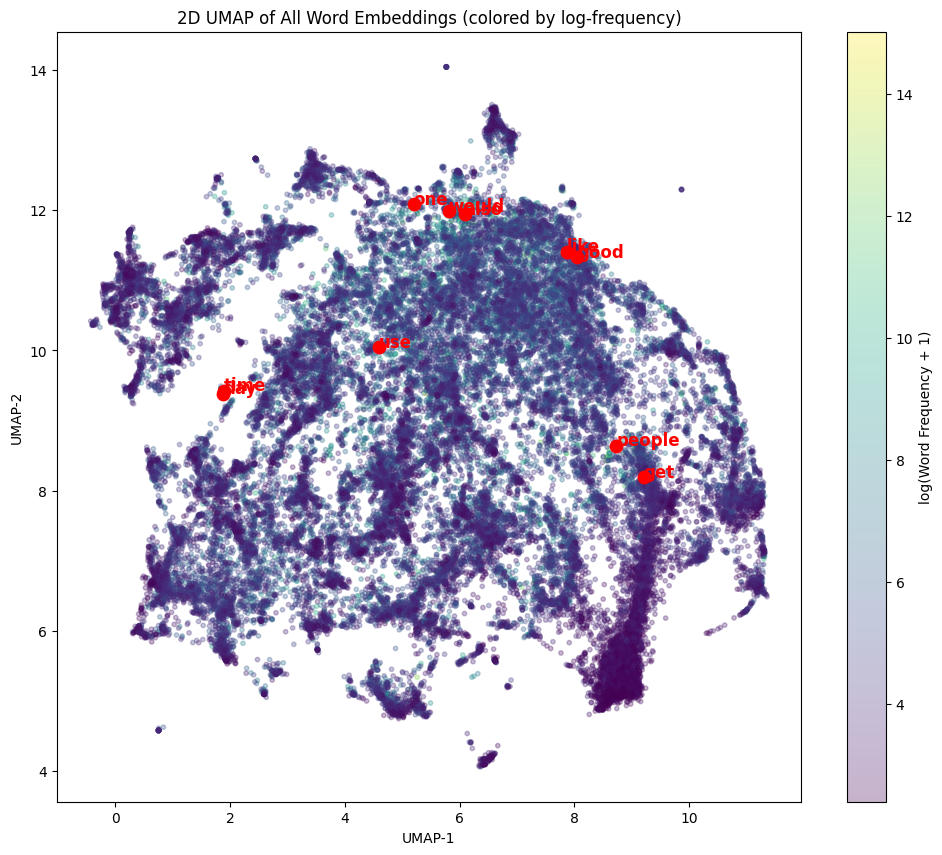

In [21]:
plot_model_umap_all(model1, highlight_words=['get', 'like', 'one', 'use', 'day', 'good', 'time', 'would', 'also', 'people'])
plot_model_umap_all(model2, highlight_words=['get', 'like', 'one', 'use', 'day', 'good', 'time', 'would', 'also', 'people'])
plot_model_umap_all(model3, highlight_words=['get', 'like', 'one', 'use', 'day', 'good', 'time', 'would', 'also', 'people'])

c:\Users\cyyua\DS\word_embedding\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Top left region high-freq words: country, american, fight
Top right region high-freq words: gratification, ancestral, chasm
Bottom left region high-freq words: vaccine, mask, vaccinate
Bottom right region high-freq words: john, adam, james
Center region high-freq words: say, would, win, time, even


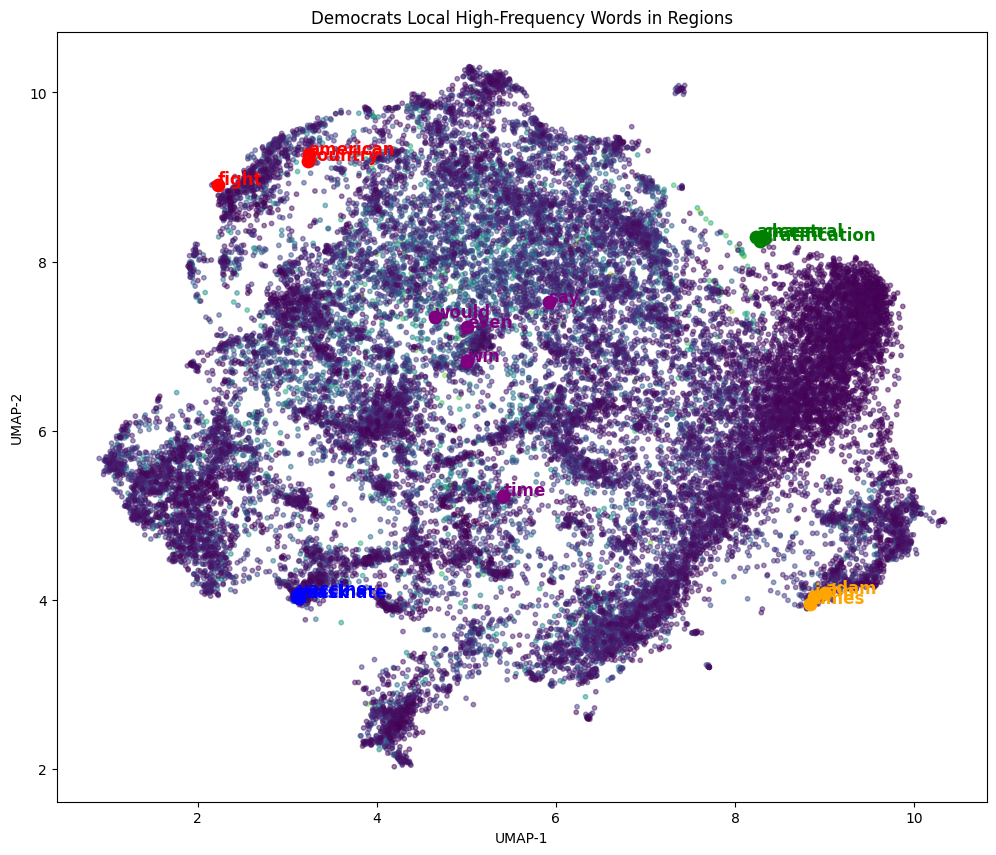

c:\Users\cyyua\DS\word_embedding\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Top left region high-freq words: give, work, pay
Top right region high-freq words: 
Bottom left region high-freq words: get, floridian, meantime
Bottom right region high-freq words: 
Center region high-freq words: trump, republican, biden, democrat, time


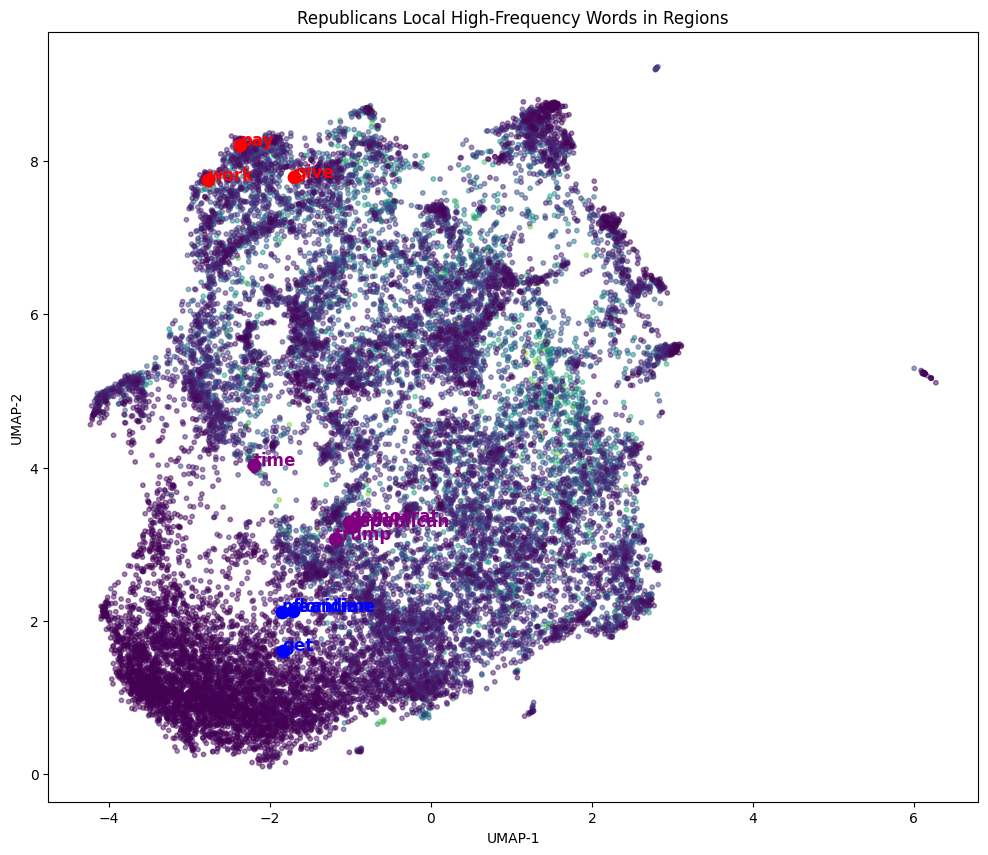

c:\Users\cyyua\DS\word_embedding\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Top left region high-freq words: life, human, seriously
Top right region high-freq words: boop_bot, ukraine_merriam, webster_bbc
Bottom left region high-freq words: away, hand, check
Bottom right region high-freq words: come, keep, woman
Center region high-freq words: remove, right, take, use, country


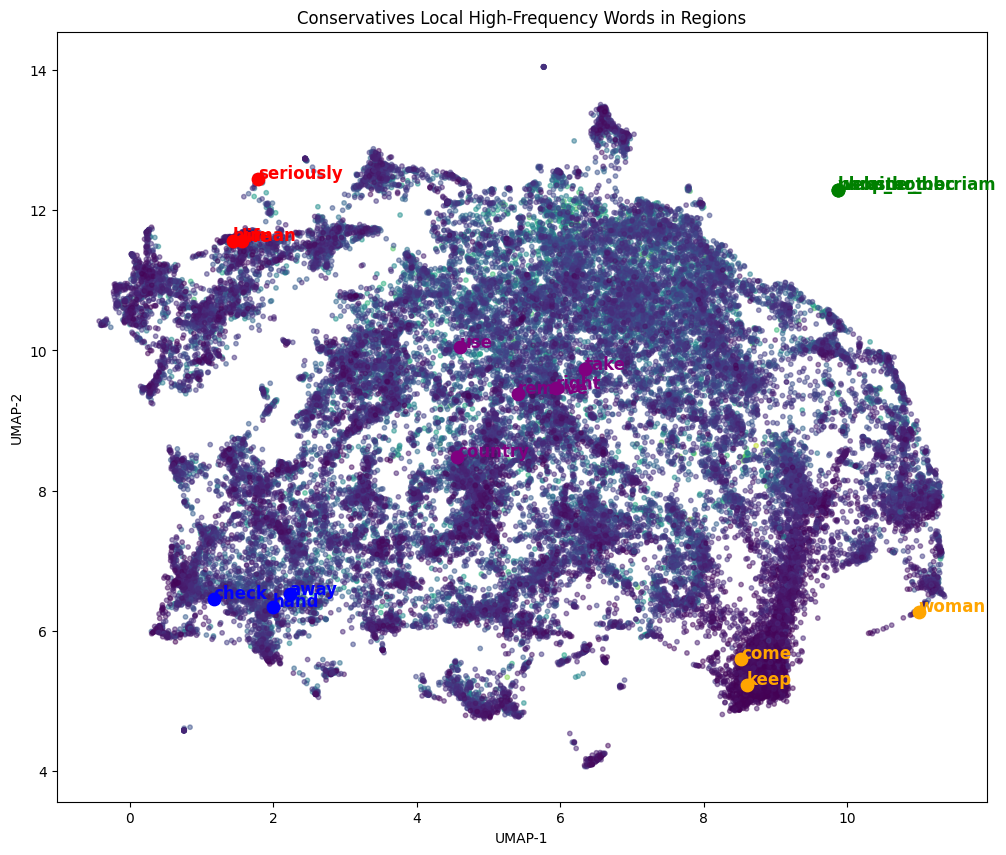

In [22]:
def find_local_highfreq_words(model, n_corners=3, n_center=5, plot=True, party=""):
    import numpy as np
    import umap.umap_ as umap
    import matplotlib.pyplot as plt

    words = list(model.wv.key_to_index.keys())
    vectors = [model.wv[w] for w in words]
    vectors = vectors - np.mean(vectors, axis=0, keepdims=True)
    vectors = vectors / np.linalg.norm(vectors, axis=1, keepdims=True)
    freqs = np.array([model.wv.get_vecattr(w, "count") for w in words])
    log_freqs = np.log1p(freqs)
    reducer = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=23)
    coords = reducer.fit_transform(vectors)
    x, y = coords[:, 0], coords[:, 1]

    # Define regions (10% margin for corners, 20% for center)
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    x_med, y_med = np.median(x), np.median(y)
    x_range, y_range = x_max - x_min, y_max - y_min

    # Top left
    mask_tl = (x < x_min + 0.25 * x_range) & (y > y_max - 0.25 * y_range)
    # Top right
    mask_tr = (x > x_max - 0.25 * x_range) & (y > y_max - 0.25 * y_range)
    # Bottom left
    mask_bl = (x < x_min + 0.25 * x_range) & (y < y_min + 0.25 * y_range)
    # Bottom right
    mask_br = (x > x_max - 0.25 * x_range) & (y < y_min + 0.25 * y_range)
    # Center
    mask_center = (np.abs(x - x_med) < 0.15 * x_range) & (np.abs(y - y_med) < 0.15 * y_range)

    def top_words(mask, n):
        idx = np.where(mask)[0]
        if len(idx) == 0:
            return []
        idx_sorted = idx[np.argsort(-freqs[idx])]
        return [words[i] for i in idx_sorted[:n]]

    tl_words = top_words(mask_tl, n_corners)
    tr_words = top_words(mask_tr, n_corners)
    bl_words = top_words(mask_bl, n_corners)
    br_words = top_words(mask_br, n_corners)
    center_words = top_words(mask_center, n_center)

    print("Top left region high-freq words:", ", ".join(tl_words))
    print("Top right region high-freq words:", ", ".join(tr_words))
    print("Bottom left region high-freq words:", ", ".join(bl_words))
    print("Bottom right region high-freq words:", ", ".join(br_words))
    print("Center region high-freq words:", ", ".join(center_words))

    if plot:
        plt.figure(figsize=(12, 10))
        plt.scatter(x, y, c=log_freqs, cmap="viridis", alpha=0.5, s=10)
        for region, region_words, color in zip(
            ["tl", "tr", "bl", "br", "center"],
            [tl_words, tr_words, bl_words, br_words, center_words],
            ["red", "green", "blue", "orange", "purple"]
        ):
            for word in region_words:
                idx = words.index(word)
                plt.scatter(x[idx], y[idx], color=color, s=80)
                plt.text(x[idx], y[idx], word, color=color, fontsize=12, weight='bold')
        plt.title(f"{party} Local High-Frequency Words in Regions")
        plt.xlabel("UMAP-1")
        plt.ylabel("UMAP-2")
        plt.show()

# 用法示例
find_local_highfreq_words(model1, party="Democrats")
find_local_highfreq_words(model2, party="Republicans")
find_local_highfreq_words(model3, party="Conservatives")

c:\Users\cyyua\DS\word_embedding\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


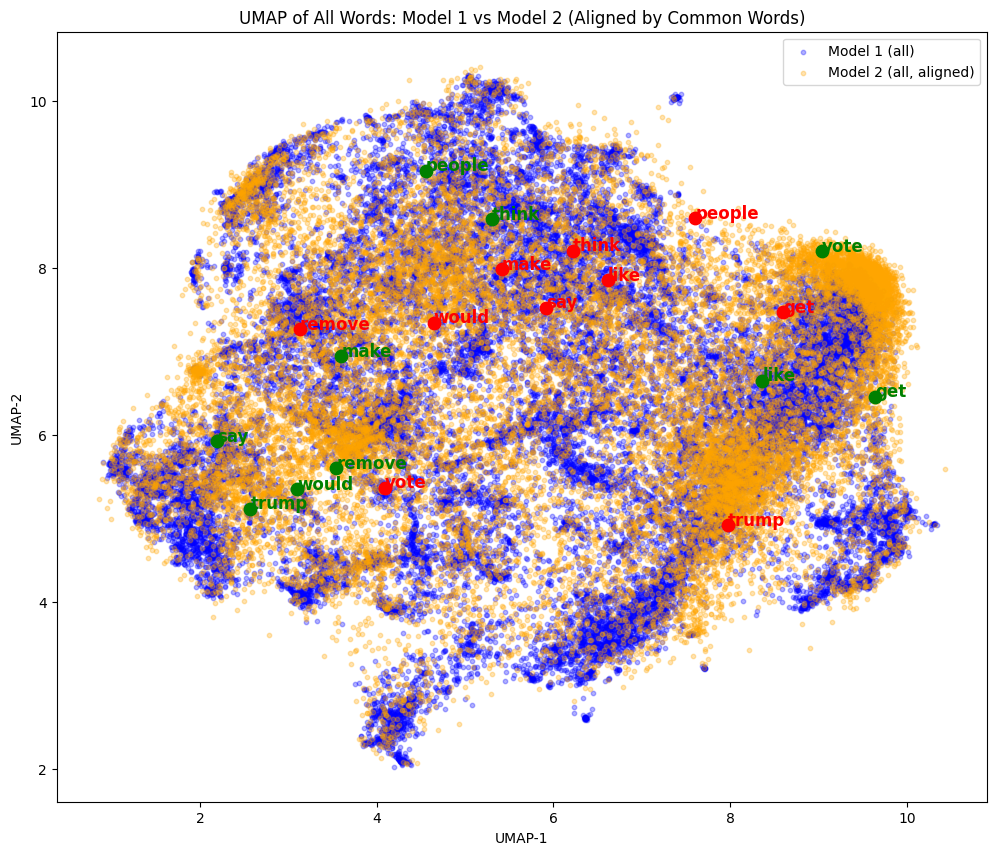

In [ ]:
def rotation_and_plot_all_words(model1, model2, highlight_words=None):
    """
    用common words做对齐，但对齐后把旋转应用到model2所有词，然后UMAP和plot全部词。
    """
    # use common words to find rotation
    vocab1 = set(model1.wv.index_to_key)
    vocab2 = set(model2.wv.index_to_key)
    common_vocab = list(vocab1.intersection(vocab2))
    vectors1 = np.array([model1.wv[word] for word in common_vocab])
    vectors2 = np.array([model2.wv[word] for word in common_vocab])
    vectors1 = vectors1 - vectors1.mean(axis=0, keepdims=True)
    vectors2 = vectors2 - vectors2.mean(axis=0, keepdims=True)
    vectors1 = vectors1 / np.linalg.norm(vectors1, axis=1, keepdims=True)
    vectors2 = vectors2 / np.linalg.norm(vectors2, axis=1, keepdims=True)
    m = vectors1.T @ vectors2
    u, _, vt = np.linalg.svd(m)
    rotation = u @ vt
    
    # apply rotation to all words in model2
    all_words1 = list(model1.wv.index_to_key)
    all_words2 = list(model2.wv.index_to_key)
    all_vecs1 = np.array([model1.wv[w] for w in all_words1])
    all_vecs2 = np.array([model2.wv[w] for w in all_words2])
    
    # use mean center and normalize for both sets before applying rotation
    all_vecs2_centered = all_vecs2 - all_vecs2.mean(axis=0, keepdims=True)
    all_vecs2_normed = all_vecs2_centered / np.linalg.norm(all_vecs2_centered, axis=1, keepdims=True)
    all_vecs2_aligned = all_vecs2_normed @ rotation

    all_vecs1_centered = all_vecs1 - all_vecs1.mean(axis=0, keepdims=True)
    all_vecs1_normed = all_vecs1_centered / np.linalg.norm(all_vecs1_centered, axis=1, keepdims=True)

    # umap and plot all words
    import umap.umap_ as umap
    import matplotlib.pyplot as plt
    reducer = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=23)
    coords1 = reducer.fit_transform(all_vecs1_normed)
    coords2 = reducer.transform(all_vecs2_aligned)

    plt.figure(figsize=(12, 10))
    plt.scatter(coords1[:, 0], coords1[:, 1], c='blue', alpha=0.3, s=10, label='Model 1 (all)')
    plt.scatter(coords2[:, 0], coords2[:, 1], c='orange', alpha=0.3, s=10, label='Model 2 (all, aligned)')

    # highlight specific words if provided
    if highlight_words:
        for word in highlight_words:
            if word in all_words1:
                idx1 = all_words1.index(word)
                plt.scatter(coords1[idx1, 0], coords1[idx1, 1], color='red', s=80, marker='o')
                plt.text(coords1[idx1, 0], coords1[idx1, 1], word, color='red', fontsize=12, weight='bold')
            if word in all_words2:
                idx2 = all_words2.index(word)
                plt.scatter(coords2[idx2, 0], coords2[idx2, 1], color='green', s=80, marker='o')
                plt.text(coords2[idx2, 0], coords2[idx2, 1], word, color='green', fontsize=12, weight='bold')
    plt.legend()
    plt.title("UMAP of All Words: Model 1 vs Model 2 (Aligned by Common Words)")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.show()

rotation_and_plot_all_words(model1, model2, highlight_words=['remove', 'trump', 'people', 'get', 'like', 'vote', 'say', 'would', 'think', 'make'])

In [26]:
def get_rotation_matrix(model1, model2):
    vocab1 = set(model1.wv.index_to_key)
    vocab2 = set(model2.wv.index_to_key)
    common_vocab = list(vocab1.intersection(vocab2))
    if len(common_vocab) == 0:
        raise ValueError("No common vocabulary between the two models.")
    vectors1 = np.array([model1.wv[word] for word in common_vocab])
    vectors2 = np.array([model2.wv[word] for word in common_vocab])
    # mean center
    vectors1 = vectors1 - vectors1.mean(axis=0, keepdims=True)
    vectors2 = vectors2 - vectors2.mean(axis=0, keepdims=True)
    # normalize
    vectors1 = vectors1 / np.linalg.norm(vectors1, axis=1, keepdims=True)
    vectors2 = vectors2 / np.linalg.norm(vectors2, axis=1, keepdims=True)
    # SVD for rotation
    m = vectors1.T @ vectors2
    u, _, vt = np.linalg.svd(m)
    rotation = u @ vt
    return rotation

rotation = get_rotation_matrix(model1, model2)

In [ ]:
def plot_models_with_shared_umap(model1, model2, rotation=None, highlight_words=None, figsize=(12, 10)):
    """
    用同一个UMAP reducer分别降维两个模型（可选对model2做旋转），并分别画图。
    """
    words1 = list(model1.wv.index_to_key)
    words2 = list(model2.wv.index_to_key)
    vecs1 = np.array([model1.wv[w] for w in words1])
    vecs2 = np.array([model2.wv[w] for w in words2])

    # mean center & normalize
    vecs1 = vecs1 - vecs1.mean(axis=0, keepdims=True)
    vecs1 = vecs1 / np.linalg.norm(vecs1, axis=1, keepdims=True)
    vecs2 = vecs2 - vecs2.mean(axis=0, keepdims=True)
    vecs2 = vecs2 / np.linalg.norm(vecs2, axis=1, keepdims=True)
    if rotation is not None:
        vecs2 = vecs2 @ rotation

    # 用同一个UMAP reducer
    import umap.umap_ as umap
    reducer = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=23)
    coords1 = reducer.fit_transform(vecs1)
    coords2 = reducer.transform(vecs2)

    # 画model1
    plt.figure(figsize=figsize)
    freqs1 = np.array([model1.wv.get_vecattr(w, "count") for w in words1])
    log_freqs1 = np.log1p(freqs1)
    sc1 = plt.scatter(coords1[:, 0], coords1[:, 1], c=log_freqs1, cmap="viridis", alpha=0.3, s=10, label='Model 1')
    plt.colorbar(sc1, label="log(Word Frequency + 1)")
    if highlight_words:
        for word in highlight_words:
            if word in words1:
                idx = words1.index(word)
                plt.scatter(coords1[idx, 0], coords1[idx, 1], color='red', s=80)
                plt.text(coords1[idx, 0], coords1[idx, 1], word, color='red', fontsize=12, weight='bold')
    plt.title("UMAP of Model 1 (shared reducer)")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.legend()
    plt.show()

    # 画model2
    plt.figure(figsize=figsize)
    freqs2 = np.array([model2.wv.get_vecattr(w, "count") for w in words2])
    log_freqs2 = np.log1p(freqs2)
    sc2 = plt.scatter(coords2[:, 0], coords2[:, 1], c=log_freqs2, cmap="viridis", alpha=0.3, s=10, label='Model 2')
    plt.colorbar(sc2, label="log(Word Frequency + 1)")
    if highlight_words:
        for word in highlight_words:
            if word in words2:
                idx = words2.index(word)
                plt.scatter(coords2[idx, 0], coords2[idx, 1], color='orange', s=80)
                plt.text(coords2[idx, 0], coords2[idx, 1], word, color='orange', fontsize=12, weight='bold')
    plt.title("UMAP of Model 2 (shared reducer, rotated)" if rotation is not None else "UMAP of Model 2 (shared reducer)")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.legend()
    plt.show()

# 用法示例
rotation = get_rotation_matrix(model1, model2)
plot_models_with_shared_umap(model1, model2, rotation=rotation, highlight_words=['remove', 'trump', 'people', 'get', 'like', 'vote', 'say', 'would', 'think', 'make'])